## Tutorial 4 Neural Network Toolbox nn
As mentioned in the previous chapter, the deep learning model can be realized by using autograd, but its abstraction level is low. If it is used to realize the deep learning model, the amount of code that needs to be written is huge. In this case, torch.nn came into being, which is a module specially designed for deep learning. The core data structure of torch.nn is `Module`, which is an abstract concept that can represent either a layer in a neural network or a neural network containing many layers. In actual use, the most common way is to inherit `nn.Module` and write your own network/layer. Let's take a look at how to use nn.Module to implement your own fully connected layer. The fully connected layer, also known as the affine layer, outputs $\textbf{y}$ and inputs $\textbf{x}$ to satisfy $\textbf{y=Wx+b}$, $\textbf{W}$ and $\textbf{b}$ is a learnable parameter.

The contents of this tutorial is based on the book and tutorial notes [^1] and [^2].

[^1]: http://docs.pytorch.org
[^2]: https://github.com/chenyuntc/pytorch-book

### 4.1 Neural network layers

Neural networks consist of different layers. The following examples illustrate some basic usage.

In [ ]:
import torch
import torch as t
from torch import nn

In [ ]:
# Input batch_size=2，dimension=3
input = t.randn(2, 3)
linear = nn.Linear(3, 4)
h = linear(input)
h

tensor([[ 0.6993, -1.1460,  0.5710, -0.2496],
        [-0.1921,  0.8154, -0.3038,  0.1873]])

We define a class object for neural networks with only a-single linear layer.

In [ ]:
class Linear(nn.Module): # inherit nn.Module
    def __init__(self, in_features, out_features):
        super(Linear, self).__init__() # Equivalent to nn.Module.__init__(self)
        self.w = nn.Parameter(t.randn(in_features, out_features))
        self.b = nn.Parameter(t.randn(out_features))
    
    def forward(self, x):
        x = x.mm(self.w) # x.@(self.w)
        return x + self.b.expand_as(x)

We create an instance named "layer" of a neural network consists of only a linear layer.

In [ ]:
layer = Linear(4,3)
input = t.randn(2,4)
output = layer(input)
output

tensor([[ 0.8600, -3.8060, -0.0796],
        [ 1.6689,  2.6452,  0.8987]], grad_fn=<AddBackward0>)

In [ ]:
for name, parameter in layer.named_parameters():
    print(name, parameter) # w and b 

w Parameter containing:
tensor([[ 1.2025,  2.7004,  0.3211],
        [-0.3202, -3.2469,  0.2630],
        [-0.7435,  1.1611, -0.8133],
        [-0.9469, -1.8018, -2.8437]], requires_grad=True)
b Parameter containing:
tensor([1.8215, 0.9360, 1.0096], requires_grad=True)


It can be seen that the implementation of the fully connected layer is very simple, and its code size does not exceed 10 lines, but the following points should be noted:
- The custom layer `Linear` must inherit `nn.Module`, and the constructor of `nn.Module` needs to be called in its constructor, namely `super(Linear, self).__init__()` or `nn.Module` .__init__(self)`, the first usage is recommended, although the second is more intuitive.
- In the constructor `__init__`, you must define the learnable parameters yourself and encapsulate them into `Parameter`. For example, in this example, we encapsulate `w` and `b` into `parameter`. `parameter` is a special `Tensor`, but it requires derivation by default (requires_grad = True). Interested readers can view the source code of the `Parameter` class through `nn.Parameter??`.
- The `forward` function implements the forward propagation process, and its input can be one or more tensors.
- No need to write a backpropagation function, nn.Module can use autograd to automatically implement backpropagation, which is much simpler than Function.
- When using, layer can be regarded as a function in mathematical concepts intuitively, and the corresponding result of input can be obtained by calling layer(input). It is equivalent to `layers.__call__(input)`. In the `__call__` function, the main call is `layer.forward(x)`, and some processing is also done on the hook. So in actual use, try to use `layer(x)` instead of `layer.forward(x)`. The hook technology will be explained below.
- The learnable parameters in `Module` can return an iterator through `named_parameters()` or `parameters()`, the former will attach a name to each parameter to make it more recognizable.

It can be seen that the fully connected layer implemented by using Module is simpler than that implemented by using `Function`, because it no longer needs to write a backpropagation function.

The following will start from the application level and give a brief introduction to Linear( fully connected layer). For more detailed usage, please refer to the documentation.

#### 4.1.2 Activation function
PyTorch implements common activation functions, and its specific interface information can be found in the official document[^3]. These activation functions can be used as independent layers. Here we will introduce the most commonly used activation function ReLU, whose mathematical expression is:
$$ReLU(x)=max(0,x)$$
[^3]: http://pytorch.org/docs/nn.html#non-linear-activations

In [ ]:
relu = nn.ReLU(inplace=True)
input = t.randn(2, 3)
print(input)
output = relu(input)
print(output) # Input entries less 0 will be outputed as 0
# Equivalent to input.clamp(min=0)

tensor([[ 1.2836,  2.0970, -0.0456],
        [ 1.5909, -1.3795,  0.5264]])
tensor([[ 1.2836,  2.0970,  0.0000],
        [ 1.5909,  0.0000,  0.5264]])


#### 4.1.3 Multilayer Perceptrons
Module can automatically detect its own `Parameter` and use it as a learning parameter. In addition to `parameter`, the Module also contains sub-`Module`, and the main Module can recursively find `parameter` in the sub-`Module`. Let's take a look at a slightly more complex network, a multi-layer perceptron.

The network structure of the multi-layer perceptron is shown in Figure 4-1. It consists of two fully connected layers and uses the $sigmoid$ function as the activation function, which is not shown in the figure.
![图4-1；多层感知机](imgs/multi_perceptron.png)

In [ ]:
class Perceptron(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        nn.Module.__init__(self)
        self.layer1 = Linear(in_features, hidden_features) # Here "Linear" is the fully connected layer defined previously
        self.layer2 = Linear(hidden_features, out_features)
    def forward(self,x):
        x = self.layer1(x)
        x = t.sigmoid(x) # Sigmoid Activation function
        return self.layer2(x)

In [ ]:
perceptron = Perceptron(3,4,1)
for name, param in perceptron.named_parameters():
    print(name, param.size())

layer1.w torch.Size([3, 4])
layer1.b torch.Size([4])
layer2.w torch.Size([4, 1])
layer2.b torch.Size([1])


It can be seen that even a slightly more complex multi-layer perceptron is still very simple to implement. In the constructor `__init__`, the previously customized Linear layer (module) can be used as a sub-module of the current module object, and its learnable parameters will also become the learnable parameters of the current module.

The naming convention of parameters in module:
- For something like `self.param_name = nn.Parameter(t.randn(3, 4))`, named `param_name`
- For the parameter in the sub-Module, the name of the current Module will be added before its name. For example, for `self.sub_module = SubModel()`, the name of a parameter in SubModel is called param_name, then the parameter name formed by splicing the two is `sub_module.param_name`.

In the above example, basically the output of each layer is directly used as the input of the next layer. This network is called a feedforward neural network. For this kind of network, it will be troublesome to write complex forward functions every time. There are two simplified methods here, ModuleList and Sequential. Among them, Sequential is a special module, which contains several sub-modules, and will pass the input layer by layer during forward propagation. ModuleList is also a special module that can contain several sub-modules and can be used like a list, but cannot directly pass input to ModuleList. The following example illustrates.

In [ ]:
# Three ways for Sequential
net1 = nn.Sequential()
net1.add_module('conv', nn.Conv2d(3, 3, 3))
net1.add_module('batchnorm', nn.BatchNorm2d(3))
net1.add_module('activation_layer', nn.ReLU())

net2 = nn.Sequential(
        nn.Conv2d(3, 3, 3),
        nn.BatchNorm2d(3),
        nn.ReLU()
        )

from collections import OrderedDict
net3= nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(3, 3, 3)),
          ('bn1', nn.BatchNorm2d(3)),
          ('relu1', nn.ReLU())
        ]))
print('net1:', net1)
print('net2:', net2)
print('net3:', net3)

net1: Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_layer): ReLU()
)
net2: Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
net3: Sequential(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
)


In [ ]:
# Submodules can be taken out by name or serial number
net1.conv, net2[0], net3.conv1

(Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)))

In [ ]:
input = t.rand(1, 3, 4, 4)
output = net1(input)
output = net2(input)
output = net3(input)
output = net3.relu1(net1.batchnorm(net1.conv(input)))

A more convenient way to create neural networks is to define a class object with highly flexible parameters.



In [ ]:
import torch
class DNN(torch.nn.Module):
    def __init__(self, width_vec: list = None):
        super(DNN, self).__init__()
        self.width_vec= width_vec

        modules = []
        if width_vec is None:
            width_vec = [1, 256, 256, 256, 1]

        # Network
        for i in range(len(width_vec) - 2):
            modules.append(
                nn.Sequential(
                    nn.Linear(width_vec[i],width_vec[i+1]),
                    nn.ReLU())
                          )

        self.net = nn.Sequential(*modules,
                          nn.Linear(width_vec[-2],width_vec[-1])
                                )

    def forward(self,x):
        output = self.net(x)
        return  output


In [ ]:
net1=DNN([1,3,5,4,2])
net1

DNN(
  (net): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=3, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=3, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=4, bias=True)
      (1): ReLU()
    )
    (3): Linear(in_features=4, out_features=2, bias=True)
  )
)

In [ ]:
net2=DNN([4,10,1])
net2

DNN(
  (net): Sequential(
    (0): Sequential(
      (0): Linear(in_features=4, out_features=10, bias=True)
      (1): ReLU()
    )
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
x=torch.randn(3,4)
net2(x)

tensor([[-0.7804],
        [-0.4626],
        [-0.1785]], grad_fn=<AddmmBackward0>)

In [ ]:
# The same way to define the class object for networks
class DNN(torch.nn.Module):
    def __init__(self, width_vec: list = None):
        super(DNN, self).__init__()
        self.width_vec= width_vec

        modules = []
        if width_vec is None:
            width_vec = [1,256, 256, 256,1]

        # Network
        for i in range(len(width_vec) - 2):
            modules.append(nn.Linear(width_vec[i],width_vec[i+1]));
            modules.append(nn.ReLU())

        self.net = nn.Sequential(*modules,
                          nn.Linear(width_vec[-2],width_vec[-1])
                     )

    def forward(self,x):
        output = self.net(x)
        return  output

In [ ]:
net2=DNN([4,10,1])
net2

In [ ]:
x=torch.randn(10,4)
net2(x)

tensor([[-0.3305],
        [-0.2769],
        [-0.2138],
        [-0.1313],
        [-0.7931],
        [-0.5069],
        [ 0.3122],
        [-0.3199],
        [-0.5102],
        [-0.7931]], grad_fn=<AddmmBackward0>)

In [ ]:
modellist = nn.ModuleList([nn.Linear(3,4), nn.ReLU(), nn.Linear(4,2)])
input = t.randn(1, 3)
for model in modellist:
    input = model(input)
# The following will report an error because modellist does not implement the forward method
# output = modelist(input)

Seeing this, readers may ask, why not just use the list that comes with Python instead of doing more? This is because `ModuleList` is a subclass of `Module`, when it is used in `Module`, it can be automatically recognized as a sub-module.

The following example illustrates.

In [ ]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.list = [nn.Linear(3, 4), nn.ReLU()]
        self.module_list = nn.ModuleList([nn.Conv2d(3, 3, 3), nn.ReLU()])
    def forward(self):
        pass
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
)

In [ ]:
for name, param in model.named_parameters():
    print(name, param.size())

module_list.0.weight torch.Size([3, 3, 3, 3])
module_list.0.bias torch.Size([3])


It can be seen that the sub-modules in the list cannot be recognized by the main module, but the sub-modules in the ModuleList can be recognized by the main module. This means that if you save the sub-module with a list, you will not be able to adjust its parameters, because they are not added to the parameters of the main module.

In addition to ModuleList, there is also ParameterList, which is a list object that can contain multiple parameters. In practical applications, the usage is similar to ModuleList. If you use list, tuple, dict and other objects in the constructor `__init__`, you must think about whether you should use ModuleList or ParameterList instead.

### 4.2 Loss function
Various loss functions are used in deep learning. These loss functions can be regarded as a special layer. PyTorch also implements these loss functions as subclasses of `nn.Module`. However, in actual use, these loss functions are usually extracted specifically, and are independent of the main model. For detailed loss usage, please refer to the document [^5]. Here, the most commonly used cross-entropy loss in classification is used as an example to illustrate.
[^5]: http://pytorch.org/docs/nn.html#loss-functions

In [ ]:
# batch_size=5, dimension of response Y is 1
Y = t.randn(5, 1)
# Suppose the 5 samples has a corresponding prediction Y_hat
Y_hat = t. randn(5,1)

# calculate the mean squared error
criterion = nn.MSELoss()
loss = criterion(Y, Y_hat)
loss

tensor(0.5493)

In [ ]:
# calculate the sumed squared error
criterion2 = nn.MSELoss(reduction='sum')
loss2 = criterion2(Y, Y_hat)
loss2

tensor(2.7466)

An example of loss functions for classificatiion

In [ ]:
# batch_size=3, calculate the score corresponding to each category (only two categories)
score = t.randn(3, 2)
# The three samples belong to categories 1, 0, and 1 respectively, and the label must be LongTensor
label = t. Tensor([1, 0, 1]). long()

# loss is no different from normal layer
criterion3 = nn.CrossEntropyLoss()
loss3 = criterion3(score, label)
loss3

tensor(0.5944)

Self-defined loss functions

In [ ]:
class LAD(torch.nn.Module):
    def __init__(self,reduction='mean'):
        super(LAD,self).__init__()
        self.reduction = reduction 
    def derive(self,x,y):
        diff = torch.sub(x,y)
        totloss = torch.sgn(diff)
        return totloss
    def forward(self,x,y):
        size = y.size()[0]
        diff = torch.sub(x,y)
        totloss = torch.abs(diff)
        if self.reduction=='mean':
            totloss=torch.sum(totloss/size)
        return totloss

In [ ]:
# batch_size=5, dimension of response Y is 1
Y = t.randn(5,1)
# Suppose the 5 samples has a corresponding prediction Y_hat
Y_hat = t. randn(5,1)

# calculate the mean least absolute value
criterion4 = LAD()
loss = criterion4(Y, Y_hat)
loss

tensor(0.8407)

### 4.3 Optimizer

PyTorch encapsulates all the optimization methods commonly used in deep learning in `torch.optim`, which is very flexible in design and can be easily extended into custom optimization methods.

All optimization methods inherit the base class `optim.Optimizer` and implement their own optimization steps. The following is an example of the most basic optimization method - stochastic gradient descent (SGD). Here you need to focus on:

- Basic usage of optimization methods
- How to set different learning rates for different parts of the model
- How to adjust the learning rate

In [ ]:
# First define a LeNet network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
                    nn.Conv2d(3, 6, 5),
                    nn.ReLU(),
                    nn.MaxPool2d(2,2),
                    nn.Conv2d(6, 16, 5),
                    nn.ReLU(),
                    nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.classifier(x)
        return x

net = Net()

In [ ]:
from torch import  optim
optimizer = optim.SGD(params=net.parameters(), lr=1)
optimizer.zero_grad() # Gradient cleared, equivalent to net.zero_grad()

input = t.randn(1, 3, 32, 32)
output = net(input)
output.backward(output) # fake backward

optimizer.step() # perform optimization

In [ ]:
# Set different learning rates for different subnetworks, often used in fine-tune
# If no learning rate is specified for a parameter, the outermost default learning rate is used
optimizer =optim.SGD([
                {'params': net.features.parameters()}, # learning rate is 1e-5
                {'params': net.classifier.parameters(), 'lr': 1e-2}
            ], lr=1e-5)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 1e-05
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [ ]:
# Only set a large learning rate for the two fully connected layers, and the learning rate of the remaining layers is small
special_layers = nn.ModuleList([net.classifier[0], net.classifier[3]])
special_layers_params = list(map(id, special_layers.parameters()))
base_params = filter(lambda p: id(p) not in special_layers_params,
                     net.parameters())

optimizer = t.optim.SGD([
            {'params': base_params},
            {'params': special_layers.parameters(), 'lr': 0.01}
        ], lr=0.001 )
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

There are two main approaches to how to adjust the learning rate. One is to modify the corresponding learning rate in optimizer.param_groups, and the other is the simpler and recommended method - to create a new optimizer. Since the optimizer is very lightweight and the construction overhead is small, a new optimizer can be built. However, for the optimizer using momentum (such as Adam), the latter will lose state information such as momentum, which may cause oscillations in the convergence of the loss function.

In [ ]:
# Method 1: Adjust the learning rate and create a new optimizer
old_lr = 0.1
optimizer1 =optim.SGD([
                {'params': net.features.parameters()},
                {'params': net.classifier.parameters(), 'lr': old_lr*0.1}
            ], lr=1e-5)
optimizer1

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 1e-05
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.010000000000000002
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [ ]:
# Method 2: Adjust learning rate, manually decay, save momentum
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1 # The learning rate is 0.1 times the previous
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 1.0000000000000002e-06
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.0010000000000000002
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### 4.4 nn.functional

There is also a very commonly used module in nn: `nn.functional`, most layers in nn have a corresponding function in `functional`. The main difference between the functions in `nn.functional` and `nn.Module` is that the layers implemented by nn.Module are a special class, which are defined by `class layer(nn.Module)`, and can be automatically extracted parameters to learn. The functions in `nn.functional` are more like pure functions, defined by `def function(input)`. The following examples illustrate the use of functional and point out the differences between the two.

In [ ]:
input = t.randn(2, 3)
model = nn.Linear(3, 4)
output1 = model(input)
output2 = nn.functional.linear(input, model.weight, model.bias)
output1 == output2

tensor([[ 1,  1,  1,  1],
        [ 1,  1,  1,  1]], dtype=torch.uint8)

In [ ]:
b = nn.functional.relu(input)
b2 = nn.ReLU()(input)
b == b2

tensor([[ 1,  1,  1],
        [ 1,  1,  1]], dtype=torch.uint8)

At this point readers may ask, when should nn.Module be used and when should nn.functional be used? The answer is simple. If the model has learnable parameters, it is best to use nn.Module. Otherwise, you can use nn.functional or nn.Module. There is not much difference in performance between the two. The specific use depends on the individual preferences. For example, activation functions (ReLU, sigmoid, tanh), pooling (MaxPool) and other layers have no learnable parameters, you can use the corresponding functional function instead, and for networks with learnable parameters such as convolution and full connection, it is recommended to use nn .Module. The following example illustrates how to use nn.Module and nn.functional together in a model. In addition, although the dropout operation has no learnable operation, it is recommended to use `nn.Dropout` instead of `nn.functional.dropout`, because the behavior of dropout is different in the two stages of training and testing, use `nn.Module` Objects can be differentiated through the `model.eval` operation.

In [ ]:
from torch.nn import functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.pool(F.relu(self.conv1(x)), 2)
        x = F.pool(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

For layers that do not have learnable parameters (activation layers, pooling layers, etc.), replace them with functions so that they do not need to be placed in the constructor `__init__`. For a module with learnable parameters, it can also be replaced by functional, but it is more cumbersome to implement, and the parameter parameter needs to be defined manually. For example, if the self-defined fully connected layer is implemented earlier, the two parameters of weight and bias can be taken out separately. , initialized as parameter in the constructor.

In [ ]:
class MyLinear(nn.Module):
    def __init__(self):
        super(MyLinear, self).__init__()
        self.weight = nn.Parameter(t.randn(3, 4))
        self.bias = nn.Parameter(t.zeros(3))
    def forward(self):
        return F.linear(input, weight, bias)

Regarding the original design intention of nn.functional and more comparisons between it and nn.Module, please refer to the forum discussion and author's explanation[^6].
[^6]: https://discuss.pytorch.org/search?q=nn.functional

### 4.5 Initialization Strategy
The initialization of parameters is very important in deep learning. Good initialization can make the model converge faster and reach a higher level, while poor initialization may quickly paralyze the model. The module parameters of nn.Module in PyTorch adopt a relatively reasonable initialization strategy, so we generally don’t need to consider it. Of course, we can also use custom initialization to replace the default initialization of the system. When we use Parameter, custom initialization is especially important, because t.Tensor() returns a random number in memory, which is likely to have a maximum value, which will cause overflow or gradient disappearance in the actual training network . The `nn.init` module in PyTorch is specially designed for initialization. If a certain initialization strategy `nn.init` is not provided, users can also initialize it directly.

In [ ]:
# Initialize with nn.init
from torch.nn import init
linear = nn. Linear(3, 4)

t. manual_seed(1)
# Equivalent to linear.weight.data.normal_(0, std)
init.xavier_normal_(linear.weight)

Parameter containing:
tensor([[ 0.3535,  0.1427,  0.0330],
        [ 0.3321, -0.2416, -0.0888],
        [-0.8140,  0.2040, -0.5493],
        [-0.3010, -0.4769, -0.0311]])

In [ ]:
# direct initialization
import math
t. manual_seed(1)

# The calculation formula for xavier initialization
std = math. sqrt(2)/math. sqrt(7.)
linear.weight.data.normal_(0,std)

tensor([[ 0.3535,  0.1427,  0.0330],
        [ 0.3321, -0.2416, -0.0888],
        [-0.8140,  0.2040, -0.5493],
        [-0.3010, -0.4769, -0.0311]])

In [ ]:
# Initialize all parameters of the model
for name, params in net.named_parameters():
    if name.find('linear') != -1:
        #init linear
        params[0] #weight
        params[1] #bias
    elif name.find('conv') != -1:
        pass
    elif name.find('norm') != -1:
        pass

### 4.6 In-depth analysis of nn.Module

If you want to understand nn.Module more deeply, it is necessary to study its principle. First look at the constructor of the nn.Module base class:
```python
def __init__(self):
    self._parameters = OrderedDict()
    self._modules = OrderedDict()
    self._buffers = OrderedDict()
    self._backward_hooks = OrderedDict()
    self._forward_hooks = OrderedDict()
    self.training = True
```
Each of these properties is explained as follows:

- `_parameters`: dictionary, save the parameters directly set by the user, `self.param1 = nn.Parameter(t.randn(3, 3))` will be detected, add a key to the dictionary as 'param', value It is the item corresponding to the parameter. The parameter in self.submodule = nn.Linear(3, 4) will not be stored here.
- `_modules`: submodule, the submodule specified by `self.submodel = nn.Linear(3, 4)` will be saved here.
- `_buffers`: buffers. If batchnorm uses the momentum mechanism, each forward pass needs to use the result of the previous forward pass.
- `_backward_hooks` and `_forward_hooks`: hook technology, used to extract intermediate variables, similar to variable hooks.
- `training`: BatchNorm and the Dropout layer adopt different strategies in the training phase and the testing phase, and determine the forward propagation strategy by judging the training value.

Among the above attributes, the key values ​​in the three dictionaries `_parameters`, `_modules` and `_buffers` can be obtained by `self.key`, and the effect is equivalent to `self._parameters['key'] `.

The following example illustrates.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Equivalent to self.register_parameter('param1' ,nn.Parameter(t.randn(3, 3)))
        self.param1 = nn.Parameter(t.rand(3, 3))
        self.submodel1 = nn.Linear(3, 4)
    def forward(self, input):
        x = self.param1.mm(input)
        x = self.submodel1(x)
        return x
net = Net()
net

Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)

In [ ]:
net._modules

OrderedDict([('submodel1', Linear(in_features=3, out_features=4, bias=True))])

In [ ]:
net._parameters

OrderedDict([('param1', Parameter containing:
              tensor([[0.8939, 0.9634, 0.3636],
                      [0.0943, 0.1294, 0.3770],
                      [0.8201, 0.8498, 0.7204]], requires_grad=True))])

In [ ]:
net.param1 # Equivalent to net._parameters['param1']

Parameter containing:
tensor([[0.8939, 0.9634, 0.3636],
        [0.0943, 0.1294, 0.3770],
        [0.8201, 0.8498, 0.7204]], requires_grad=True)

In [ ]:
for name, param in net.named_parameters():
    print(name, param.size())

param1 torch.Size([3, 3])
submodel1.weight torch.Size([4, 3])
submodel1.bias torch.Size([4])


In [ ]:
for name, submodel in net.named_modules():
    print(name, submodel)

 Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)
submodel1 Linear(in_features=3, out_features=4, bias=True)


In [ ]:
bn = nn.BatchNorm1d(2)
input = t.rand(3, 2)
output = bn(input)
bn._buffers

OrderedDict([('running_mean', tensor([0.0776, 0.0543])),
             ('running_var', tensor([0.9095, 0.9145])),
             ('num_batches_tracked', tensor(1))])

nn.Module may be nested layer by layer in actual use. A module contains several sub-modules, and each sub-module contains more sub-modules. In order to facilitate users to access each sub-module, nn.Module implements many methods, such as the function `children` to view direct sub-modules, and the function `module` to view all sub-modules (including the current module). Corresponding to it are the functions `named_childen` and `named_modules`, which can return their names while returning the module list.

In [ ]:
input = t.arange(0, 12).view(3, 4)
model = nn.Dropout()
# During the training phase, about half of the numbers will be randomly set to 0
model(input)

RuntimeError: ignored

In [ ]:
model.training  = False
# During testing, dropout does nothing
model(input)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

For batchnorm, dropout, instancenorm and other layers with a huge gap between the training and testing phases, if the training value is not set to True during the test, it may have a great impact, which must be paid attention to in actual use. Although the sub-module can be set to train and eval mode by directly setting the `training` attribute, this method is cumbersome, because if a model has multiple dropout layers, it is necessary to specify the training attribute for each dropout layer. A more recommended way is to call the `model.train()` function, which will set all the training attributes in the current module and its sub-modules to True. Correspondingly, the `model.eval()` function will set the training attribute Both are set to False.

In [ ]:
print(net.training, net.submodel1.training)
net.eval()
net.training, net.submodel1.training

True True


(False, False)

In [ ]:
list(net.named_modules())

[('', Net(
    (submodel1): Linear(in_features=3, out_features=4, bias=True)
  )), ('submodel1', Linear(in_features=3, out_features=4, bias=True))]

`register_forward_hook` and `register_backward_hook`, the functions of these two functions are similar to `register_hook` of the variable function, which can register hooks during forward or backward propagation of the module. The hook function (hook) will be executed after each forward pass execution. The hook function of forward propagation has the following form: `hook(module, input, output) -> None`, while the backpropagation has the following form: `hook(module, grad_input, grad_output) -> Tensor or None`. The hook function should not modify the input and output, and should be deleted in time after use, so as to avoid running the hook every time to increase the running load. The hook function is mainly used to obtain some intermediate results, such as the output of a certain layer in the middle or the gradient of a certain layer. These results should have been written in the forward function, but if these processes are specially added in the forward function, the processing logic may be more complicated. At this time, it is more appropriate to use the hook technology. Consider a scenario below. There is a pre-trained model. It is necessary to extract the output of a certain layer (not the last layer) of the model as a feature for classification, but do not want to modify its original model definition file. At this time, Hook functions can be used. The pseudocode of the implementation is given below.
```python
model = VGG()
features = t.Tensor()
def hook(module, input, output):
    '''Copy the output of this layer to features'''
    features.copy_(output.data)
    
handle = model.layer8.register_forward_hook(hook)
_ = model(input)
# Delete after using the hook
handle.remove()
```

The behavior of the `nn.Module` object in the constructor looks a bit weird. If you want to really grasp the principle, you need to look at the two magic methods `__getattr__` and `__setattr__`. There are two commonly used buildin methods `getattr` and `setattr` in Python, `getattr(obj, 'attr1')` is equivalent to `obj.attr`, if the `getattr` function cannot find the required attribute, Python will Instead, call the `obj.__getattr__('attr1')` method, that is, if the `getattr` function cannot be found, it will be handled by the `__getattr__` function. If `__getattr__` is not implemented or `__getattr__` cannot be processed, AttributeError will be raised. `setattr(obj, 'name', value)` is equivalent to `obj.name=value`, if the obj object implements the `__setattr__` method, setattr will directly call `obj.__setattr__('name', value)`, Otherwise call the buildin method. in conclusion:
- result = obj.name will call the buildin function `getattr(obj, 'name')`, if the attribute is not found, it will call `obj.__getattr__('name')`
- obj.name = value will call the buildin function `setattr(obj, 'name', value)`, if the obj object implements the `__setattr__` method, `setattr` will directly call `obj.__setattr__('name', value' )`

nn.Module implements a custom `__setattr__` function. When executing `module.name=value`, it will judge whether the value is a `Parameter` or `nn.Module` object in `__setattr__`, and if so, these The object is added to the two dictionaries `_parameters` and `_modules`, and if it is another type of object, such as `Variable`, `list`, `dict`, etc., the default operation is called and the value is saved in `__dict__ `Middle.

In [ ]:
module = nn.Module()
module.param = nn.Parameter(t.ones(2, 2))
module._parameters

OrderedDict([('param', Parameter containing:
              tensor([[1., 1.],
                      [1., 1.]], requires_grad=True))])

In [ ]:
submodule1 = nn.Linear(2, 2)
submodule2 = nn.Linear(2, 2)
module_list =  [submodule1, submodule2]
# For the list object, call the buildin function and save it in __dict__
module.submodules = module_list
print('_modules: ', module._modules)
print("__dict__['submodules']:",module.__dict__.get('submodules'))

_modules:  OrderedDict()
__dict__['submodules']: [Linear(in_features=2, out_features=2, bias=True), Linear(in_features=2, out_features=2, bias=True)]


In [ ]:
module_list = nn.ModuleList(module_list)
module.submodules = module_list
print('ModuleList is instance of nn.Module: ', isinstance(module_list, nn.Module))
print('_modules: ', module._modules)
print("__dict__['submodules']:", module.__dict__.get('submodules'))

ModuleList is instance of nn.Module:  True
_modules:  OrderedDict([('submodules', ModuleList(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
))])
__dict__['submodules']: None


Because the item in `_modules` and `_parameters` is not saved in `__dict__`, the default getattr method cannot get it, so `nn.Module` implements a custom `__getattr__` method, if the default `getattr` If it cannot be processed, call the custom `__getattr__` method and try to get it from the three dictionaries `_modules`, `_parameters` and `_buffers`.

In [ ]:
getattr(module, 'training') # Equivalent to module.training
# error
# module.__getattr__('training')

True

In [ ]:
module.attr1 = 2
getattr(module, 'attr1')
# Error
# module.__getattr__('attr1')

2

In [ ]:
# That is, module.param will call module.__getattr__('param')
getattr(module, 'param')

Parameter containing:
tensor([[ 1.,  1.],
        [ 1.,  1.]])

It is very simple to save the model in PyTorch. All Module objects have a state_dict() function that returns all the state data of the current Module. After saving these state data, you can use the `model.load_state_dict()` function to load the state when you use the model next time. The optimizer also has a similar mechanism, but generally there is no need to save the running state of the optimizer.

In [ ]:
# Save the model
t.save(net.state_dict(), 'net.pth')

# Load the saved model
net2 = Net()
net2.load_state_dict(t.load('net.pth'))

In fact, there is another saving method, but it is not recommended because it is heavily dependent on the model definition method and file path structure, which is prone to problems.

In [ ]:
t.save(net, 'net_all.pth')
net2 = t.load('net_all.pth')
net2

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Net(
  (submodel1): Linear(in_features=3, out_features=4)
)

It is also very simple to run the Module on the GPU, just two steps:
- model = model.cuda(): dump all parameters of the model to the GPU
- input.cuda(): Place the input data on the GPU

As for how to parallelize calculations on multiple GPUs, PyTorch also provides two functions for simple and efficient parallel GPU calculations
- nn.parallel.data_parallel(module, inputs, device_ids=None, output_device=None, dim=0, module_kwargs=None)
- class torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)

It can be seen that the parameters of the two are very similar. Through the `device_ids` parameter, you can specify which GPUs to optimize on, and output_device specifies which GPU to output to. The only difference is that the former directly uses multi-GPU parallel computing to obtain results, while the latter returns a new module that can automatically perform parallel acceleration on multi-GPU.

```
# method 1
new_net = nn.DataParallel(net, device_ids=[0, 1])
output = new_net(input)

# method 2
output = nn.parallel.data_parallel(new_net, input, device_ids=[0, 1])
```

The DataParallel parallel method is to divide the data input into a batch into multiple parts and send them to the corresponding GPUs for calculation, and the gradients obtained by each GPU are accumulated. All data related to the Module will also be replicated in multiple copies by means of shallow replication. It should be noted here that the attributes in the module should be read-only.

### 4.7 The relationship between nn and autograd
nn.Module also uses autograd technology, and its main job is to realize forward propagation. In the forward function, the various operations performed by nn.Module on the input tensor essentially use the autograd technology. Here you need to compare the difference between autograd.Function and nn.Module:
- autograd.Function takes advantage of Tensor's extension of autograd technology, and realizes a new operation op for autograd, not only to realize forward propagation but also to manually realize back propagation
- nn.Module uses autograd technology to expand the function of nn and realize more layers in deep learning. Just implement the forward propagation function, and autograd will automatically implement backpropagation
- nn.functional is a collection of some autograd operations, which are encapsulated functions

As two methods to expand the PyTorch interface, how should we choose in actual use? If a certain operation is not yet supported in autograd, then only the forward propagation and back propagation corresponding to the Function interface can be realized. If it is more complicated to use the autograd interface at some point, you can use Function to aggregate multiple operations to achieve optimization, just like `Sigmoid` implemented in Chapter 3, which is faster than directly using autograd's low-level operations. And if you just want to add a certain layer in deep learning, it is simpler and more efficient to use nn.Module for encapsulation.

### 4.8 Small test: Deep Nonparametric Regression
Now we have basic knowledges about how to build neural networks, to define loss functions, and 

In [12]:
import torch
import torch as t
from IPython import display

device = t.device('cpu') #If you want to use gpu, change to t.device('cuda:0')

In [19]:
# Set the random number seed to ensure that the following output is consistent when running on different computers
t.manual_seed(1000) 

# We use the function "Data" of the package "torch.utils.data" to pack the generate data
import torch.utils.data as Data

def get_fake_data(batch_size=128):
    ''' Generate random data: y=5*sin(2*pi*x) plus some noise'''
    x = t.rand(batch_size, 1, device=device) 
    y = 5*t.sin(2*t.pi*x) + t.randn(batch_size, 1, device=device)
    return Data.TensorDataset(x, y)

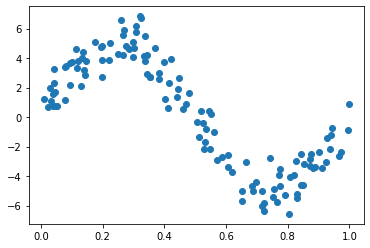

In [39]:
# Note that the data x,y are contained in a packed object "dataset"
dataset = get_fake_data(batch_size=128)
x=dataset[:][0];y=dataset[:][1]

# Let's see the resulting x-y distribution
from matplotlib import pyplot as plt
plt.scatter(x.squeeze().cpu().numpy(), y.squeeze().cpu().numpy())

torch.Size([100, 1])

In [30]:
# Let's define the class object of multilayer perceptrons
class DNN(torch.nn.Module):
    def __init__(self, width_vec: list = None):
        super(DNN, self).__init__()
        self.width_vec= width_vec

        modules = []
        if width_vec is None:
            width_vec = [1,256,256,256,1]

        # Network
        for i in range(len(width_vec) - 2):
            modules.append(nn.Linear(width_vec[i],width_vec[i+1]));
            modules.append(nn.ReLU())

        self.net = nn.Sequential(*modules,
                          nn.Linear(width_vec[-2],width_vec[-1])
                     )

    def forward(self,x):
        output = self.net(x)
        return  output

In [58]:
# Create an instantce of shallow multilayer perceptron with architechture (dimension of each layer) being (1,32,1)
# Input dimension=1, Output dimension=2 , Dimension of the hidden layer=32
net=DNN([1,32,1])
net

DNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [59]:
# We use the Adam algorithm
from torch import  optim
optimizer = optim.Adam(params=net.parameters(),betas=[0.9,0.99],lr=0.01)


In [60]:
# We choose the loss function to be least square loss function, that is to create an instance from the class "nn.MSELoss()"
loss_function = nn.MSELoss()

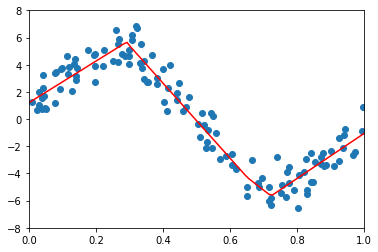

loss value 0.9902713298797607


In [61]:
# Firstly, we prepare dataloader to stochasticly sample mini-batch data from the whole dataset
BATCH_SIZE = int(32) # Each time we use 16 samples to calculate gradient
data_loader = Data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0,)
Epochs=1000

for ii in range(Epochs):
  for step, (x_batch, y_batch) in enumerate(data_loader):
        x_batch, y_batch = x_batch.float(), y_batch.float()
        net.train()
        # forward：calculate loss
        prediction = net(x_batch)     # input x and predict based on x
        loss = loss_function(prediction, y_batch)     # must be (1. nn output, 2. target)
        

        # backward： calculate the gradient
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        # Update parameters
        optimizer.step()        # apply gradients
        net.eval()

  if ii%50 ==0:
        # drawing
        display.clear_output(wait=True)
        x0 = t.linspace(0,1,100).view(-1, 1)
        y0 = net(x0)
        plt.plot(x0.detach().numpy(), y0.detach().numpy(),color='r') # predicted
        plt.scatter(x.numpy(), y.numpy()) # true data
        plt.xlim(0, 1)
        plt.ylim(-8, 8)
        plt.show()
        plt.pause(0.8)
        print('loss value', loss.item())